# 数据准备

In [5]:
import os  
import torch  
import pandas as pd  
import matplotlib.pyplot as plt
  
    #step1:加载数据集
# 设置数据集的路径  
data_dir = '../../DataFiles/ODS/strain'   
# 创建空的列表来存储所有的DataFrame  
X_data0 = []  
y_data0 = []
# 遍历指定目录下的所有文件  
for filename in os.listdir(data_dir):  
    if filename.endswith('.csv'):  
        # 构建文件的完整路径  
        file_path = os.path.join(data_dir, filename)  
        # 读取Excel文件  
        df = pd.read_csv(file_path)
        serie=df.iloc[:, 0]
        version_without_extension = filename.rsplit(".", 1)[0] 
        serie.name=version_without_extension
        # 将读取的DataFrame添加到列表中  
        X_data0.append(serie)
        y_data0.append(version_without_extension)

    #step2:遍历X_data0中的每个DataFrame，并删除非数字数据  
cleaned_data = []  
for df in X_data0:  
    df_cleaned = df[pd.to_numeric(df, errors='coerce').notnull()]  
    cleaned_data.append(df_cleaned)  
 

    #step3:将X_data0中的每个DataFrame的所有元素变为float类型 
for i, df in enumerate(cleaned_data):  
    X_data0[i] = df.astype(float) 

# 初始化X_data1来存储结果  
X_data1 = []  
  
# 遍历X_data0中的每个Series  
for series in X_data0:  
    # 计算步长（由于重叠率为50%，步长为序列长度的一半）  
    step_size = 1024  # 因为2048的一半是1024，且我们想要50%的重叠  
    # 初始化一个空的list来存储子序列  
    subsequences = []  
    # 使用range和步长来生成子序列  
    for i in range(0, len(series) - 2048+ 1, step_size):  
        # 确保切片是一维的，并转换为Series（虽然这里切片已经是Series）  
        subsequence = series.iloc[i:i+2048]  
        subsequences.append(subsequence) 
    X_data1.append(subsequences)  
print((type(X_data1),len(X_data1),len(X_data1[0])))

import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from keras.utils import to_categorical
import time  
from keras.callbacks import Callback  
import torch 

# 假设 X_data1 已经定义好了  
all_data = []  
all_labels = []  
  
for sublist in X_data1:  
    for series in sublist:  
        # 假设每个series是pandas Series  
        all_data.append(series.values)  
        all_labels.append(series.name)  
  
# 将数据转换为numpy数组  
data_array = np.array(all_data)  
# 将标签转换为编码  

label_encoder = LabelEncoder()  
labels_encoded = label_encoder.fit_transform(all_labels)  
  
# 如果需要one-hot编码  
labels_one_hot = to_categorical(labels_encoded)  
  
# 这里你可能需要reshape data_array 以符合LSTM的输入要求  
# LSTM通常要求输入形状为 (samples, time_steps, features)  
# 假设每个series的长度相同，或者你可以填充/截断它们以具有相同的长度  
# time_steps = data_array.shape[1]  # 假设所有series长度相同  
# data_array = data_array.reshape(-1, time_steps, 1)  # 增加一个维度以匹配LSTM的输入要求

# 分割数据集  
X_train, X_temp, y_train, y_temp = train_test_split(data_array, labels_one_hot, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print((type(X_train),X_train.shape,type(y_train),y_train.shape))
X_train_first_12 = X_train[:12]  

(<class 'list'>, 2, 1814)
(<class 'numpy.ndarray'>, (2412, 2048), <class 'numpy.ndarray'>, (2412, 2))


# EMD的实现和效果展示
- 我的个人理解：[EMD](https://github.com/RosenKreutzs/ClassifyBearing/blob/master/LSTM/EXPLAINATION_EMD.md)；

## step1:对原始信号进行EMD操作，获得IMF组；

time_mean:0.21015443404515585;L2_mean:0.0;nmse_mean:0.0


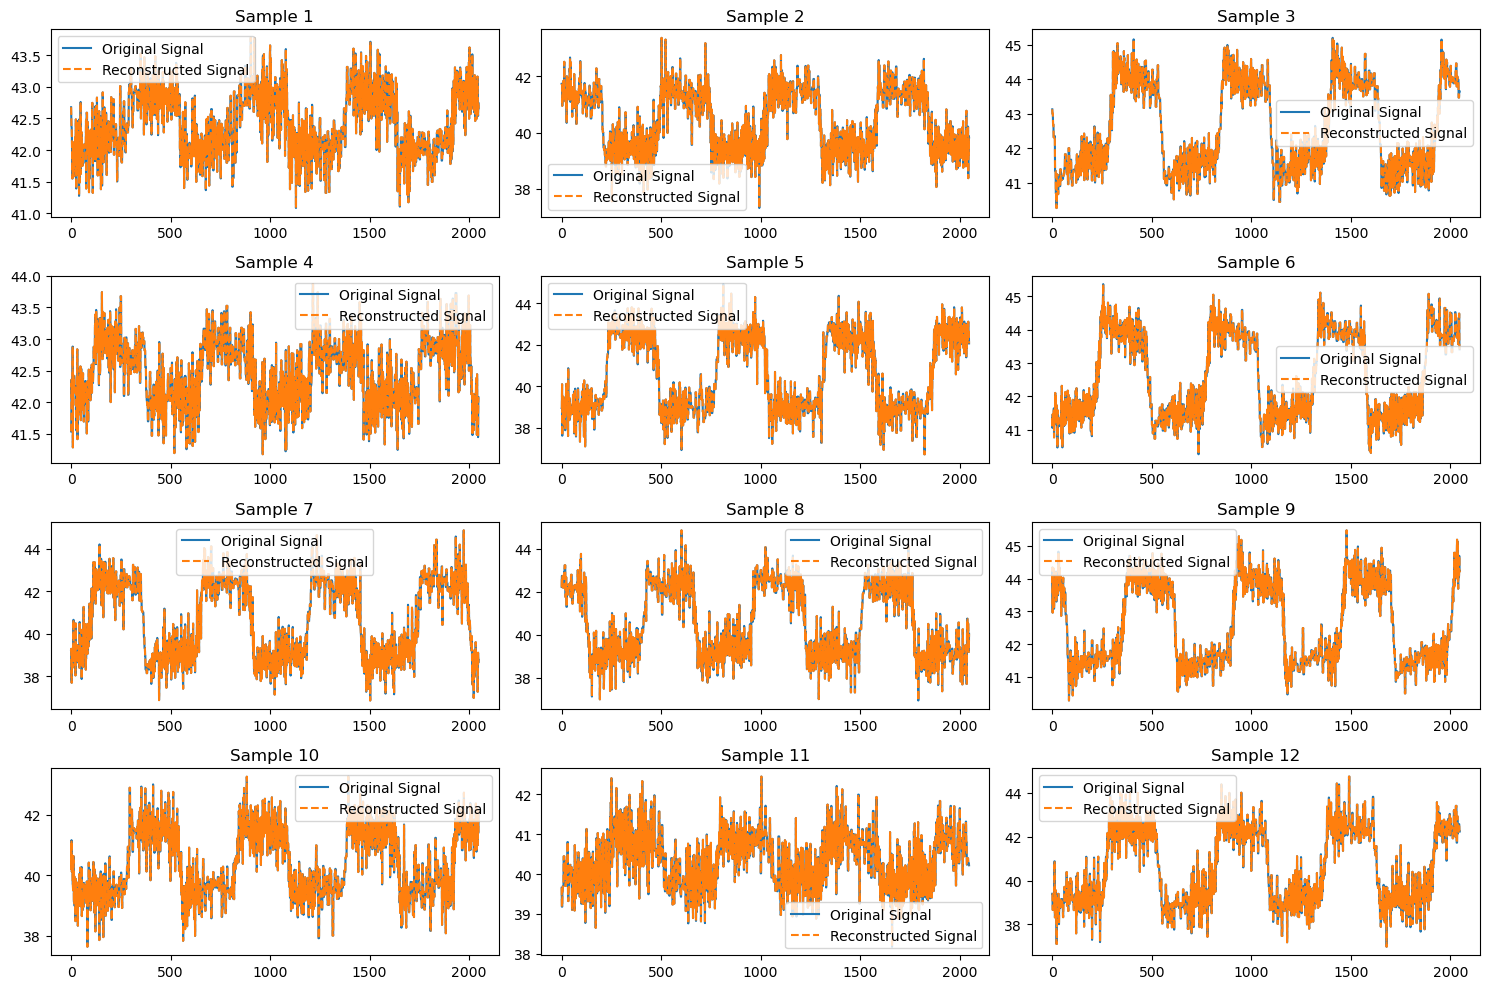

In [8]:
import subprocess  
  
# 执行shell命令并等待完成  
result = subprocess.run(['pip', 'install','EMD-signal'], capture_output=True, text=True) 
import numpy as np  
from PyEMD import EMD  
import time     
  
# 初始化一个空列表来存储重构后的信号  
reconstructed_signals = [] 
IMFs_list=[]
start_time = time.time() 
# 对每条序列进行EMD分解和重构  
for signal in X_train_first_12:  
    # 创建EMD对象并传入信号  
    emd = EMD()  
    IMFs = emd.emd(signal)  
    IMFs_list.append(IMFs)
    residual = signal - np.sum(IMFs, axis=0)
    # 重构信号：将所有本征模态函数（IMF）和残差相加  
    reconstructed_signal = np.sum(IMFs, axis=0) + residual  
      
    # 将重构后的信号添加到列表中  
    reconstructed_signals.append(reconstructed_signal)  
end_time = time.time()

# 将重构后的信号列表转换为numpy数组（如果需要的话）  
reconstructed_signals_array = np.array(reconstructed_signals)  

# 你可以选择检查第一条重构信号与原始信号之间的差异
# 两个向量（或数组）之间的欧几里得距离（或L2范数）
L2_mean=0
nmse_mean=0

for i in range(12):
    #欧几里得距离（或L2范数）
    L2_mean=L2_mean+np.linalg.norm(X_train_first_12[i]- reconstructed_signals_array[i])
    
    #归一化均方误差（NMSE）
        # 计算MSE  
    mse = np.mean((X_train_first_12[i] - reconstructed_signals_array[i]) ** 2)  
        # 计算原始信号的能量  
    original_energy = np.sum(X_train_first_12[i] ** 2) 
        # 计算NMSE  
    nmse_mean = nmse_mean + mse / original_energy  

L2_mean=L2_mean/(i+1)
nmse_mean=nmse_mean/(i+1)
time_mean=(end_time - start_time)/(i+1)
print(f"time_mean:{time_mean};L2_mean:{L2_mean};nmse_mean:{nmse_mean}")


## step2:显示IMF组和原始信号和重构信号；
- 每个IMF都代表了原始信号的某种固有振动模式信息；
- IMF包含的信息可通过[筛选](../../ModelsContrast/110spmemdlstmvibration.ipynb)后，以达到去噪的效果；之后再重构；

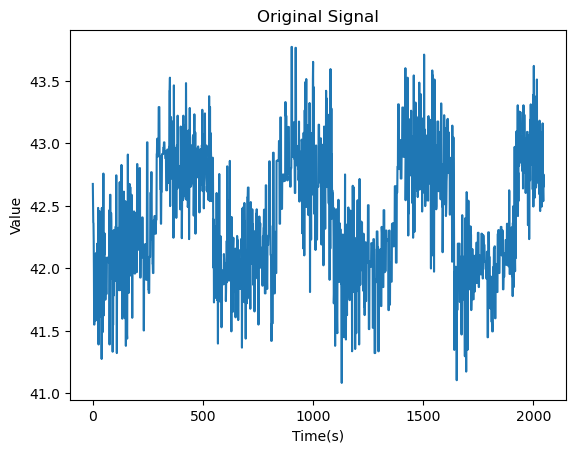

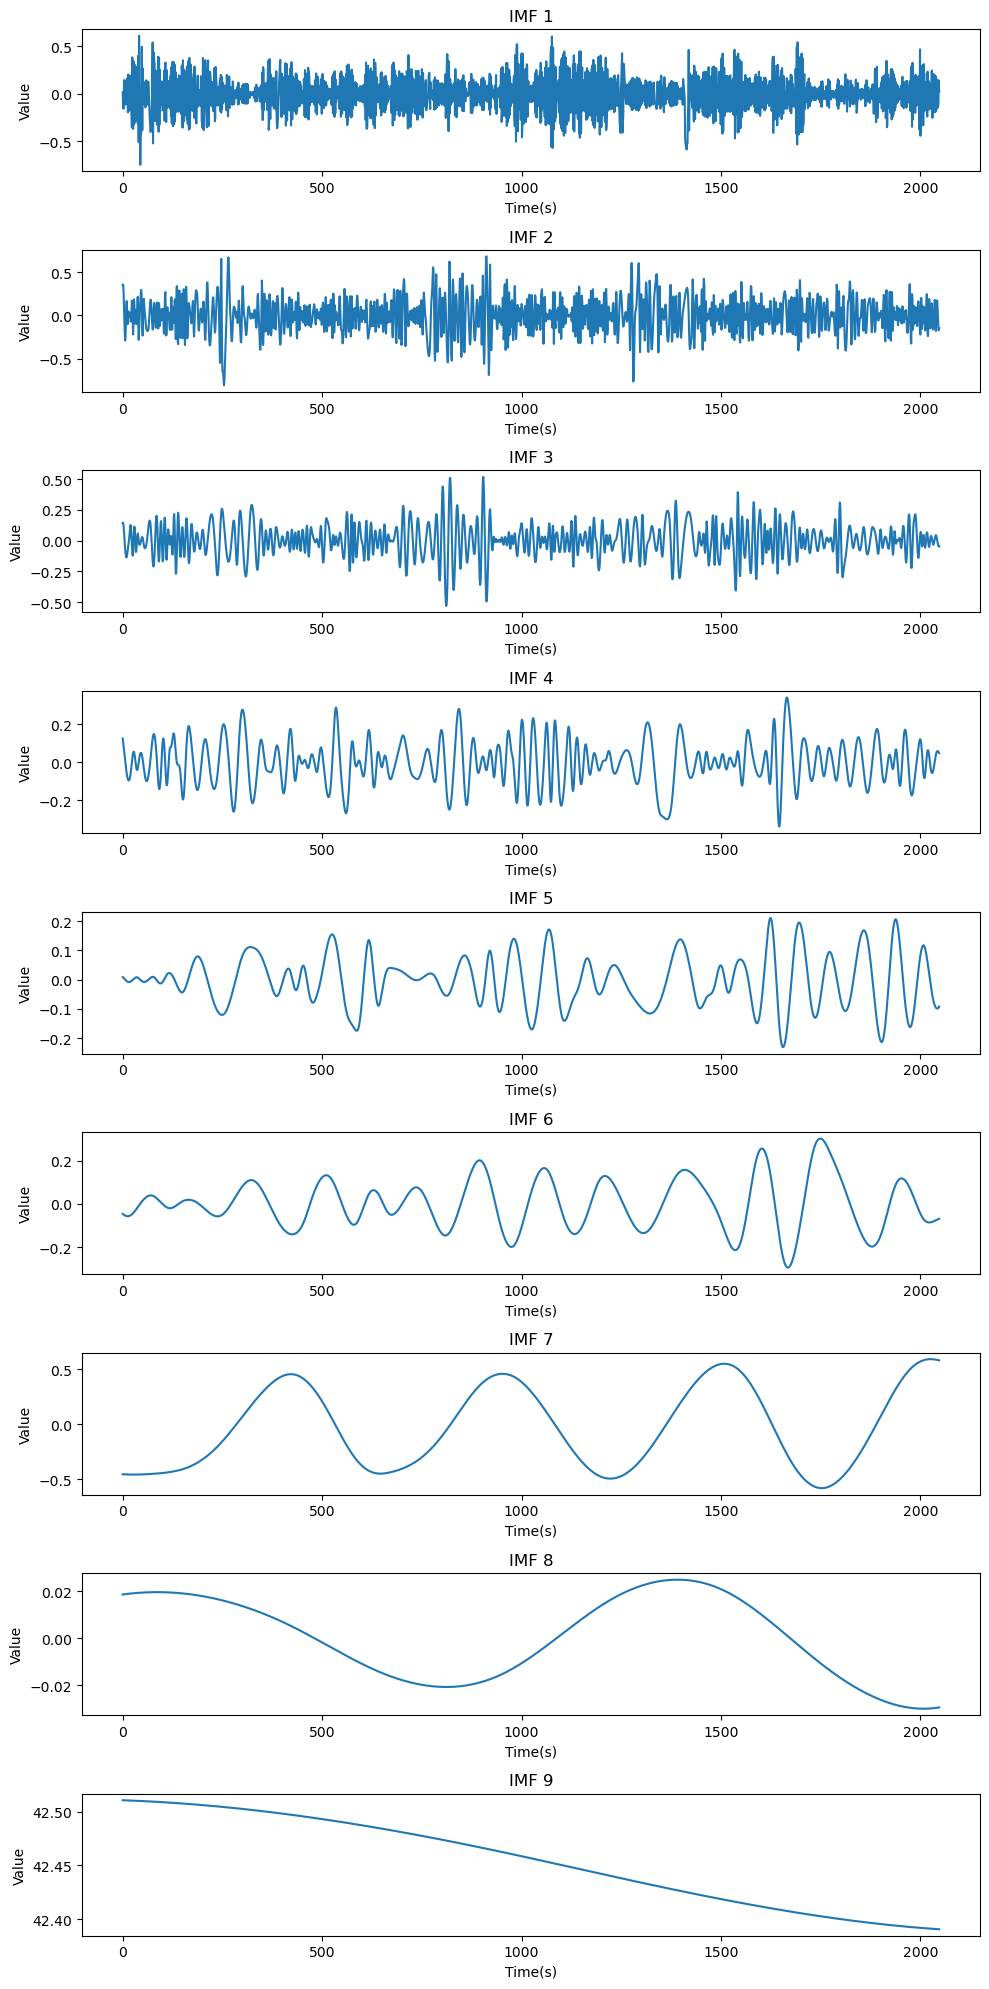

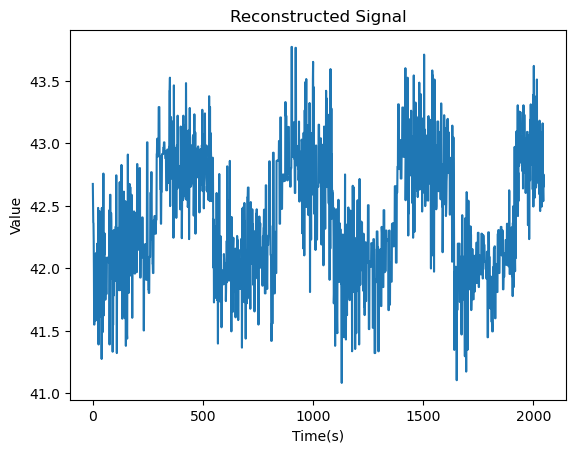

In [15]:
import matplotlib.pyplot as plt  

    # 原始信号图
plt.plot(X_train_first_12[0])  
plt.title("Original Signal")
plt.xlabel('Time(s)')  # 设置x轴标签  
plt.ylabel('Value')  # 设置y轴标签  
plt.show()

    #IMF组图
# 创建一个包含9个子图的图形，每个子图占据1行1列  
fig, axs = plt.subplots(9, 1, figsize=(10, 20))  # 调整figsize以适合你的需要  
  
# 遍历每个子图和对应的数据  
for i, ax in enumerate(axs):  
    ax.plot(IMFs_list[0][i])  # 绘制第i个一维序列  
    ax.set_title(f'IMF {i+1}')  # 设置子图的标题  
    ax.set_xlabel('Time(s)')  # 设置x轴标签  
    ax.set_ylabel('Value')  # 设置y轴标签  
  
# 调整子图之间的间距  
plt.tight_layout()  
  
# 显示图形  
plt.show()

    # 重构信号图
plt.plot(reconstructed_signals[0])  
plt.title("Reconstructed Signal")
plt.xlabel('Time(s)')  # 设置x轴标签  
plt.ylabel('Value')  # 设置y轴标签  
plt.show()